In [ ]:
!pip install -U datasets transformers sklearn matplotlib

Part 0: Loading LIAR Dataset from Hugging Face...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/5.16k [00:00<?, ?B/s]

liar.py:   0%|          | 0.00/6.41k [00:00<?, ?B/s]

LIAR dataset labels (from Hugging Face): ['false', 'half-true', 'mostly-true', 'true', 'barely-true', 'pants-fire']

Part 1: Constructing Knowledge Graph from LIAR Dataset...


Generating Triples: 100%|██████████| 10269/10269 [00:00<00:00, 14114.35it/s]


KG Constructed: 52697 triples, 17050 entities, 4 relations.

Part 2: ConvE Model Implementation and Training...
Starting ConvE training for 5 epochs on cpu...


ConvE Epoch 1/5: 100%|██████████| 412/412 [00:39<00:00, 10.40it/s]


ConvE Epoch 1/5, Loss: 0.2117


ConvE Epoch 2/5: 100%|██████████| 412/412 [00:40<00:00, 10.27it/s]


ConvE Epoch 2/5, Loss: 0.0018


ConvE Epoch 3/5: 100%|██████████| 412/412 [00:43<00:00,  9.42it/s]


ConvE Epoch 3/5, Loss: 0.0008


ConvE Epoch 4/5: 100%|██████████| 412/412 [00:39<00:00, 10.50it/s]


ConvE Epoch 4/5, Loss: 0.0006


ConvE Epoch 5/5: 100%|██████████| 412/412 [00:40<00:00, 10.26it/s]


ConvE Epoch 5/5, Loss: 0.0005
ConvE training finished.


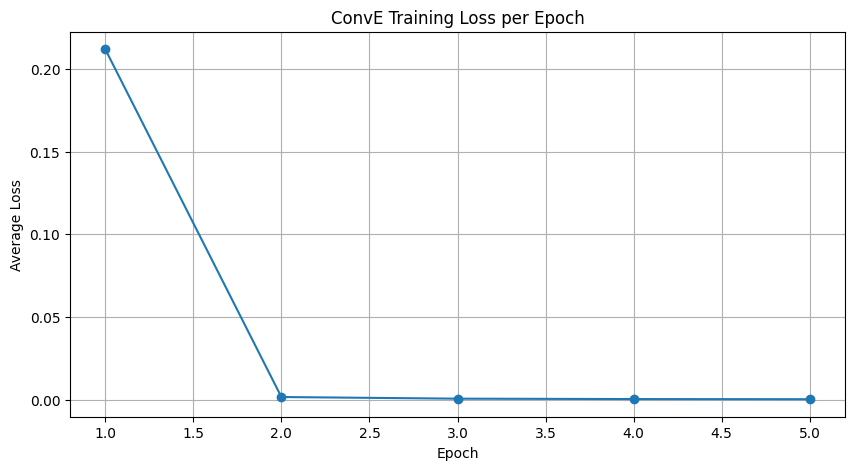

Shape of learned entity embeddings: torch.Size([17050, 100])

Part 3: DistilBERT Model Training with ConvE Embeddings...
Number of labels for DistilBERT: 6


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassificationWithKG were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting DistilBERT with KG fine-tuning for 3 epochs on cpu...


DistilBERT Epoch 1/3 Training: 100%|██████████| 642/642 [1:40:22<00:00,  9.38s/it]


DistilBERT Epoch 1 Training - Loss: 1.7157, Accuracy: 0.2432


DistilBERT Epoch 1/3 Validation: 100%|██████████| 81/81 [03:50<00:00,  2.84s/it]


DistilBERT Epoch 1 Validation - Loss: 1.6922, Accuracy: 0.2679


DistilBERT Epoch 2/3 Training: 100%|██████████| 642/642 [1:40:28<00:00,  9.39s/it]


DistilBERT Epoch 2 Training - Loss: 1.6053, Accuracy: 0.3138


DistilBERT Epoch 2/3 Validation: 100%|██████████| 81/81 [03:46<00:00,  2.80s/it]


DistilBERT Epoch 2 Validation - Loss: 1.6805, Accuracy: 0.2609


DistilBERT Epoch 3/3 Training: 100%|██████████| 642/642 [1:40:06<00:00,  9.36s/it]


DistilBERT Epoch 3 Training - Loss: 1.3845, Accuracy: 0.4388


DistilBERT Epoch 3/3 Validation: 100%|██████████| 81/81 [03:46<00:00,  2.80s/it]


DistilBERT Epoch 3 Validation - Loss: 1.8067, Accuracy: 0.2609
DistilBERT with KG fine-tuning finished.


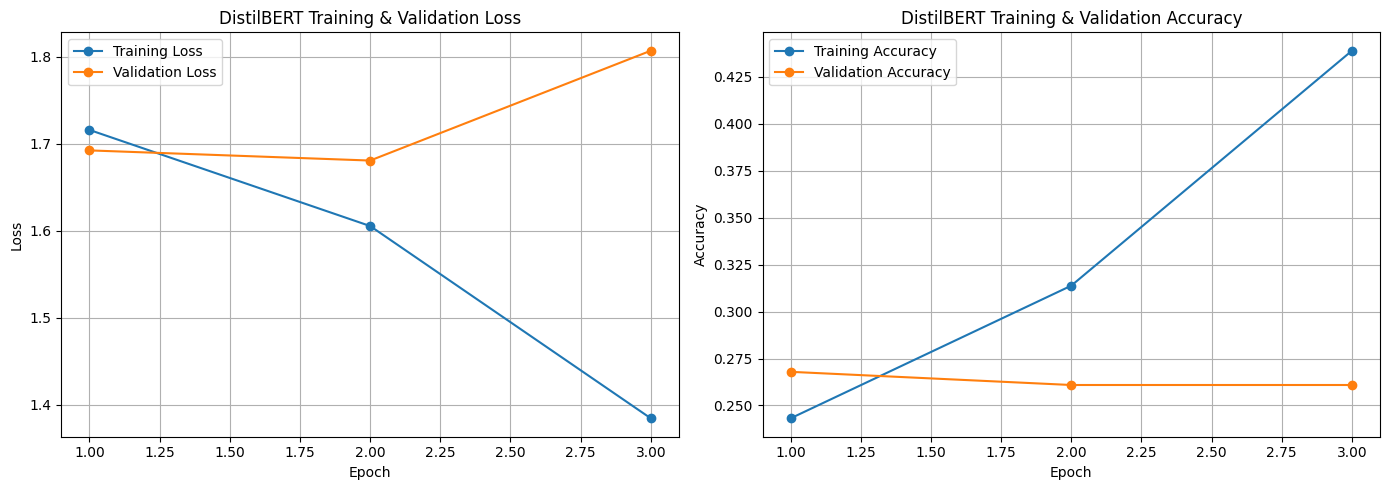


--- Script Finished ---


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from collections import defaultdict
from tqdm import tqdm
import random
from sklearn.model_selection import train_test_split # For splitting data for DistilBERT
# sklearn.preprocessing.LabelEncoder is not strictly needed if using HF integer labels directly
import matplotlib.pyplot as plt

# --- Configuration ---
# ConvE Config
CONVE_EMBEDDING_DIM = 100
CONVE_FEATURE_MAP_DROP = 0.2
CONVE_INPUT_DROP = 0.2
CONVE_HIDDEN_DROP = 0.3
CONVE_LR = 0.003
CONVE_BATCH_SIZE = 128
CONVE_EPOCHS = 5 # Keep low for demonstration

# DistilBERT Config
DISTILBERT_MODEL_NAME = 'distilbert-base-uncased'
DISTILBERT_MAX_LENGTH = 128 # Max sequence length for DistilBERT
DISTILBERT_BATCH_SIZE = 16
DISTILBERT_LR = 2e-5
DISTILBERT_EPOCHS = 3 # Keep low for demonstration

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Part 0: Load LIAR Dataset from Hugging Face ---
print("Part 0: Loading LIAR Dataset from Hugging Face...")
try:
    from datasets import load_dataset
except ImportError:
    print("datasets library not installed. Please install it: pip install datasets")
    exit()

def load_liar_hf_dataset():
    """Loads the LIAR dataset from Hugging Face and converts to Pandas DataFrames."""
    try:
        liar_hf_dataset = load_dataset("liar")
        train_df = liar_hf_dataset['train'].to_pandas()
        validation_df = liar_hf_dataset['validation'].to_pandas()
        test_df = liar_hf_dataset['test'].to_pandas()

        # Get label names
        label_names = liar_hf_dataset['train'].features['label'].names
        print(f"LIAR dataset labels (from Hugging Face): {label_names}")

        # Add string label column for KG construction if needed, and for consistency
        for df in [train_df, validation_df, test_df]:
            df['label_str'] = df['label'].apply(lambda x: label_names[x])
            df.dropna(subset=['statement', 'label'], inplace=True) # Ensure essential columns are not NaN

        return train_df, validation_df, test_df, label_names
    except Exception as e:
        print(f"Error loading LIAR dataset from Hugging Face: {e}")
        return None, None, None, None

liar_train_df, liar_validation_df, liar_test_df, liar_label_names = load_liar_hf_dataset()

if liar_train_df is None:
    print("Halting due to missing LIAR data from Hugging Face.")
    exit()

# For KG construction, we'll use the training split
liar_df_for_kg = liar_train_df.copy()
# For DistilBERT, we'll use liar_train_df and liar_validation_df

# --- Part 1: Knowledge Graph Construction from LIAR Dataset ---
print("\nPart 1: Constructing Knowledge Graph from LIAR Dataset...")

def create_kg_from_df(df, label_names_list):
    """Creates entities, relations, and triples from the LIAR DataFrame."""
    entities = set()
    relations = set(['stated_by', 'has_subject', 'affiliated_with_party', 'has_label_str']) # Using label_str
    triples = []

    # Use 'id' column from HF dataset which is already unique string
    statement_ids = ["stmt_" + str(id_val) for id_val in df['id'].unique()]
    speakers = ["spkr_" + str(s).replace(" ", "_") for s in df['speaker'].unique() if pd.notna(s)]
    subjects = ["subj_" + str(s).replace(" ", "_") for s in df['subject'].unique() if pd.notna(s)]
    parties = ["party_" + str(p).replace(" ", "_") for p in df['party_affiliation'].unique() if pd.notna(p)]

    # Use the string labels obtained from HF for KG entities
    labels_str_entities = ["lbl_" + str(l).replace(" ", "_") for l in df['label_str'].unique() if pd.notna(l)]


    all_entities_list = statement_ids + speakers + subjects + parties + labels_str_entities
    for entity in all_entities_list:
        entities.add(entity)

    entity_to_id = {entity: i for i, entity in enumerate(entities)}
    relation_to_id = {relation: i for i, relation in enumerate(relations)}
    id_to_entity = {i: entity for entity, i in entity_to_id.items()}

    num_entities = len(entities)
    num_relations = len(relations)

    for _, row in tqdm(df.iterrows(), total=df.shape[0], desc="Generating Triples"):
        stmt_id_entity = "stmt_" + str(row['id'])

        if pd.notna(row['speaker']):
            speaker_entity = "spkr_" + str(row['speaker']).replace(" ", "_")
            if stmt_id_entity in entity_to_id and speaker_entity in entity_to_id:
                triples.append((entity_to_id[stmt_id_entity], relation_to_id['stated_by'], entity_to_id[speaker_entity]))
            if pd.notna(row['party_affiliation']):
                party_entity = "party_" + str(row['party_affiliation']).replace(" ", "_")
                if speaker_entity in entity_to_id and party_entity in entity_to_id:
                     triples.append((entity_to_id[speaker_entity], relation_to_id['affiliated_with_party'], entity_to_id[party_entity]))

        if pd.notna(row['subject']):
            subject_list = str(row['subject']).split(',')
            for subj_item in subject_list: # Renamed subj to subj_item to avoid conflict
                subj_entity = "subj_" + subj_item.strip().replace(" ", "_")
                if stmt_id_entity in entity_to_id and subj_entity in entity_to_id:
                    triples.append((entity_to_id[stmt_id_entity], relation_to_id['has_subject'], entity_to_id[subj_entity]))

        if pd.notna(row['label_str']): # Use label_str for KG
             label_entity_str = "lbl_" + str(row['label_str']).replace(" ", "_")
             if stmt_id_entity in entity_to_id and label_entity_str in entity_to_id:
                 triples.append((entity_to_id[stmt_id_entity], relation_to_id['has_label_str'], entity_to_id[label_entity_str]))

    return triples, entity_to_id, relation_to_id, id_to_entity, num_entities, num_relations

kg_triples, entity_to_id, relation_to_id, id_to_entity, \
num_entities, num_relations = create_kg_from_df(liar_df_for_kg, liar_label_names)
print(f"KG Constructed: {len(kg_triples)} triples, {num_entities} entities, {num_relations} relations.")


# --- Part 2: ConvE Model Implementation and Training ---
print("\nPart 2: ConvE Model Implementation and Training...")

class ConvE(nn.Module):
    def __init__(self, num_entities, num_relations, embedding_dim,
                 input_drop=0.2, feature_map_drop=0.2, hidden_drop=0.3):
        super(ConvE, self).__init__()
        self.entity_embeddings = nn.Embedding(num_entities, embedding_dim)
        self.relation_embeddings = nn.Embedding(num_relations, embedding_dim)

        self.input_dp = nn.Dropout(input_drop)
        self.feature_map_dp = nn.Dropout2d(feature_map_drop)
        self.hidden_dp = nn.Dropout(hidden_drop)

        self.reshape_h = 10
        self.reshape_w = embedding_dim // self.reshape_h
        if embedding_dim % self.reshape_h != 0:
            raise ValueError(f"Embedding dim {embedding_dim} must be divisible by reshape_h {self.reshape_h}")

        self.conv1 = nn.Conv2d(1, 32, (3, 3), 1, 0, bias=True)
        self.bn0 = nn.BatchNorm2d(1)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm1d(embedding_dim)

        conv_out_h = 2 * self.reshape_h - 3 + 1
        conv_out_w = self.reshape_w - 3 + 1
        self.fc_input_size = 32 * conv_out_h * conv_out_w
        self.fc = nn.Linear(self.fc_input_size, embedding_dim)

    def forward(self, h_idx, r_idx):
        h_emb = self.entity_embeddings(h_idx)
        r_emb = self.relation_embeddings(r_idx)
        h_emb_reshaped = h_emb.view(-1, 1, self.reshape_h, self.reshape_w)
        r_emb_reshaped = r_emb.view(-1, 1, self.reshape_h, self.reshape_w)
        stacked_embeddings = torch.cat([h_emb_reshaped, r_emb_reshaped], dim=2)
        stacked_embeddings = self.bn0(stacked_embeddings)
        x = self.input_dp(stacked_embeddings)
        x = self.conv1(x)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.feature_map_dp(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.hidden_dp(x)
        x = self.bn2(x)
        x = torch.relu(x)
        scores = torch.mm(x, self.entity_embeddings.weight.transpose(1, 0))
        return scores

class KGTriplesDataset(Dataset):
    def __init__(self, triples, num_entities):
        self.triples = triples
        self.num_entities = num_entities
    def __len__(self):
        return len(self.triples)
    def __getitem__(self, idx):
        h, r, t = self.triples[idx]
        target_vector = torch.zeros(self.num_entities)
        target_vector[t] = 1.0
        return torch.tensor(h, dtype=torch.long), torch.tensor(r, dtype=torch.long), target_vector

conve_model = ConvE(num_entities, num_relations, CONVE_EMBEDDING_DIM,
                    CONVE_INPUT_DROP, CONVE_FEATURE_MAP_DROP, CONVE_HIDDEN_DROP).to(DEVICE)
optimizer_conve = optim.Adam(conve_model.parameters(), lr=CONVE_LR)
criterion_conve = nn.BCEWithLogitsLoss()

train_dataset_conve = KGTriplesDataset(kg_triples, num_entities)
train_loader_conve = DataLoader(train_dataset_conve, batch_size=CONVE_BATCH_SIZE, shuffle=True)

print(f"Starting ConvE training for {CONVE_EPOCHS} epochs on {DEVICE}...")
conve_model.train()
conve_loss_history = []
for epoch in range(CONVE_EPOCHS):
    epoch_loss = 0
    for h_batch, r_batch, target_batch in tqdm(train_loader_conve, desc=f"ConvE Epoch {epoch+1}/{CONVE_EPOCHS}"):
        h_batch, r_batch, target_batch = h_batch.to(DEVICE), r_batch.to(DEVICE), target_batch.to(DEVICE)
        optimizer_conve.zero_grad()
        scores = conve_model(h_batch, r_batch)
        loss = criterion_conve(scores, target_batch)
        loss.backward()
        optimizer_conve.step()
        epoch_loss += loss.item()
    avg_epoch_loss = epoch_loss/len(train_loader_conve)
    conve_loss_history.append(avg_epoch_loss)
    print(f"ConvE Epoch {epoch+1}/{CONVE_EPOCHS}, Loss: {avg_epoch_loss:.4f}")
print("ConvE training finished.")

# Plot ConvE Training Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, CONVE_EPOCHS + 1), conve_loss_history, marker='o', linestyle='-')
plt.title('ConvE Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True)
plt.show()


conve_model.eval()
with torch.no_grad():
    final_entity_embeddings = conve_model.entity_embeddings.weight.cpu()
print(f"Shape of learned entity embeddings: {final_entity_embeddings.shape}")


# --- Part 3: DistilBERT Model Training with ConvE Embeddings ---
print("\nPart 3: DistilBERT Model Training with ConvE Embeddings...")

try:
    from transformers import DistilBertTokenizerFast, DistilBertModel, DistilBertPreTrainedModel
except ImportError:
    print("transformers library not installed. Please install it: pip install transformers sklearn matplotlib datasets")
    exit()

# Use the integer labels directly from Hugging Face dataset for DistilBERT
num_distilbert_labels = len(liar_label_names) # Number of unique labels
print(f"Number of labels for DistilBERT: {num_distilbert_labels}")

tokenizer = DistilBertTokenizerFast.from_pretrained(DISTILBERT_MODEL_NAME)

class LiarKGDistilBertDataset(Dataset):
    def __init__(self, dataframe, tokenizer, entity_to_id_map, kg_embeddings_tensor, max_len):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.entity_to_id_map = entity_to_id_map
        self.kg_embeddings_tensor = kg_embeddings_tensor
        self.max_len = max_len
        self.default_kg_embedding = torch.zeros(CONVE_EMBEDDING_DIM) # For missing speakers

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        statement = str(row['statement'])
        label_id = row['label'] # Using the original integer label from HF dataset

        inputs = self.tokenizer.encode_plus(
            statement,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=False,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        speaker_kg_embedding = self.default_kg_embedding.clone() # Important to clone
        if pd.notna(row['speaker']):
            speaker_entity_name = "spkr_" + str(row['speaker']).replace(" ", "_")
            if speaker_entity_name in self.entity_to_id_map:
                speaker_idx = self.entity_to_id_map[speaker_entity_name]
                speaker_kg_embedding = self.kg_embeddings_tensor[speaker_idx].clone()

        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'kg_feature': speaker_kg_embedding.detach(), # Detach from graph if it's from model weights
            'labels': torch.tensor(label_id, dtype=torch.long)
        }

train_distilbert_dataset = LiarKGDistilBertDataset(liar_train_df, tokenizer, entity_to_id, final_entity_embeddings, DISTILBERT_MAX_LENGTH)
val_distilbert_dataset = LiarKGDistilBertDataset(liar_validation_df, tokenizer, entity_to_id, final_entity_embeddings, DISTILBERT_MAX_LENGTH)

train_distilbert_loader = DataLoader(train_distilbert_dataset, batch_size=DISTILBERT_BATCH_SIZE, shuffle=True)
val_distilbert_loader = DataLoader(val_distilbert_dataset, batch_size=DISTILBERT_BATCH_SIZE)


class DistilBertForSequenceClassificationWithKG(DistilBertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.distilbert = DistilBertModel(config)
        self.kg_feature_dim = CONVE_EMBEDDING_DIM

        self.pre_classifier = nn.Linear(config.dim + self.kg_feature_dim, config.dim)
        self.classifier = nn.Linear(config.dim, config.num_labels)
        self.dropout = nn.Dropout(config.seq_classif_dropout)
        self.init_weights()

    def forward(
        self, input_ids=None, attention_mask=None, kg_feature=None, labels=None,
        head_mask=None, inputs_embeds=None, output_attentions=None,
        output_hidden_states=None, return_dict=None,
    ):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict
        distilbert_output = self.distilbert(
            input_ids=input_ids, attention_mask=attention_mask, head_mask=head_mask,
            inputs_embeds=inputs_embeds, output_attentions=output_attentions,
            output_hidden_states=output_hidden_states, return_dict=return_dict,
        )
        hidden_state = distilbert_output[0]
        pooled_output = hidden_state[:, 0]

        if kg_feature is not None:
            kg_feature = kg_feature.to(pooled_output.device)
            combined_output = torch.cat((pooled_output, kg_feature), dim=1)
        else:
            combined_output = torch.cat((pooled_output, torch.zeros(pooled_output.size(0), self.kg_feature_dim).to(pooled_output.device)), dim=1)

        combined_output = self.pre_classifier(combined_output)
        combined_output = nn.ReLU()(combined_output)
        combined_output = self.dropout(combined_output)
        logits = self.classifier(combined_output)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        if not return_dict:
            output = (logits,) + distilbert_output[1:]
            return ((loss,) + output) if loss is not None else output

        from transformers.modeling_outputs import SequenceClassifierOutput
        return SequenceClassifierOutput(
            loss=loss, logits=logits, hidden_states=distilbert_output.hidden_states,
            attentions=distilbert_output.attentions,
        )

distilbert_kg_model = DistilBertForSequenceClassificationWithKG.from_pretrained(
    DISTILBERT_MODEL_NAME, num_labels=num_distilbert_labels).to(DEVICE)
optimizer_distilbert = optim.AdamW(distilbert_kg_model.parameters(), lr=DISTILBERT_LR)

print(f"Starting DistilBERT with KG fine-tuning for {DISTILBERT_EPOCHS} epochs on {DEVICE}...")

distilbert_train_loss_history = []
distilbert_train_acc_history = []
distilbert_val_loss_history = []
distilbert_val_acc_history = []

for epoch in range(DISTILBERT_EPOCHS):
    distilbert_kg_model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    for batch in tqdm(train_distilbert_loader, desc=f"DistilBERT Epoch {epoch+1}/{DISTILBERT_EPOCHS} Training"):
        optimizer_distilbert.zero_grad()
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        kg_feature = batch['kg_feature'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)

        outputs = distilbert_kg_model(input_ids=input_ids, attention_mask=attention_mask,
                                     kg_feature=kg_feature, labels=labels)
        loss = outputs.loss
        logits = outputs.logits
        loss.backward()
        optimizer_distilbert.step()

        train_loss += loss.item()
        predictions = torch.argmax(logits, dim=1)
        train_correct += (predictions == labels).sum().item()
        train_total += labels.size(0)

    avg_train_loss = train_loss / len(train_distilbert_loader)
    train_accuracy = train_correct / train_total
    distilbert_train_loss_history.append(avg_train_loss)
    distilbert_train_acc_history.append(train_accuracy)
    print(f"DistilBERT Epoch {epoch+1} Training - Loss: {avg_train_loss:.4f}, Accuracy: {train_accuracy:.4f}")

    distilbert_kg_model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for batch in tqdm(val_distilbert_loader, desc=f"DistilBERT Epoch {epoch+1}/{DISTILBERT_EPOCHS} Validation"):
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            kg_feature = batch['kg_feature'].to(DEVICE)
            labels = batch['labels'].to(DEVICE)
            outputs = distilbert_kg_model(input_ids=input_ids, attention_mask=attention_mask,
                                         kg_feature=kg_feature, labels=labels)
            loss = outputs.loss
            logits = outputs.logits
            val_loss += loss.item()
            predictions = torch.argmax(logits, dim=1)
            val_correct += (predictions == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_loss / len(val_distilbert_loader)
    val_accuracy = val_correct / val_total
    distilbert_val_loss_history.append(avg_val_loss)
    distilbert_val_acc_history.append(val_accuracy)
    print(f"DistilBERT Epoch {epoch+1} Validation - Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.4f}")

print("DistilBERT with KG fine-tuning finished.")

# Plot DistilBERT Training and Validation Metrics
epochs_range = range(1, DISTILBERT_EPOCHS + 1)
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, distilbert_train_loss_history, marker='o', linestyle='-', label='Training Loss')
plt.plot(epochs_range, distilbert_val_loss_history, marker='o', linestyle='-', label='Validation Loss')
plt.title('DistilBERT Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, distilbert_train_acc_history, marker='o', linestyle='-', label='Training Accuracy')
plt.plot(epochs_range, distilbert_val_acc_history, marker='o', linestyle='-', label='Validation Accuracy')
plt.title('DistilBERT Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print("\n--- Script Finished ---")